## **1. getting started**
`wavesolve` is a lightweight package to solve for scalar and vector eigenmodes of waveguides. It employs the finite-element method (specifically, Galerkin's method - read more <a href = "finite_element_method_notes.pdf"> here</a>.) The general workflow for `wavesolve` is the following:

1. Specify the waveguide boundaries (e.g. the outer cladding radius and the core radius for step-index optical fibers.) 
2. Create a mesh, that is contained/divided by the boundaries you specified.
3. Assign an index of refraction to each bounded area in the mesh.
4. Solve the eigenvector problem associated with the waveguide mesh, giving the guided modes.

To implement the above, `wavesolve` provides the following submodules:

1. `mesher`: a super basic set of functions which generate finite element meshes for waveguides like optical fibers and photonic lanterns
2. `waveguide`: a more advanced, object-oriented submodule which can be used to generate meshes for arbitrary waveguides, with a finer degree of control.
3. `fe_solver`: a set of functions used to solve for waveguide eigenmodes, taking finite element meshes as inputs.

In **Section 1**, I provide some basic quickstart examples. **Section 2** goes over usage for the `waveguide` submodule, which enables the creation of more advanced waveguides. **Section 3** provides documentation for the `fe_solver` submodule.  **Section 4** includes some worked examples for photonic crystal fibers.

### 1.1 **making meshes: optical fiber**
In this section, we will numerically compute the guided modes of a circular, step-index optical fiber. These are the well-known "linearly polarized" (LP) modes. First, we must define our waveguide geometry and create a mesh to represent that geometry. For this, we will use the basic `mesher` module; for more advanced mesh generation, see the `waveguide` module, covered in Section 2.

In [52]:
wavelength = 1.55 # um
rclad = 10 # um, because our wavelength is in um. this is the cladding radius
rcore = 5 # um. this is the core radius
res = 32 # this sets the number of line segments forming the core-cladding boundary. higher -> finer mesh
         # at the expense of slower calculation and more memory use.

from wavesolve import mesher

### easy way to make a fiber ###
fib = mesher.fiber_mesh(rclad,rcore,res)

Next, we assign index of refraction values to each region in the mesh, using a dictionary. `fiber_mesh` produces two regions, identified as `core` and `cladding`. After specifying which regions of the mesh have what refractive index, we can plot using `mesher.plot_mesh()`. This function plots all the triangles in the mesh, as well as the edge midpoints (which are used in quadratic-triangles finite-element analysis); each triangle is colored according to the refractive index.

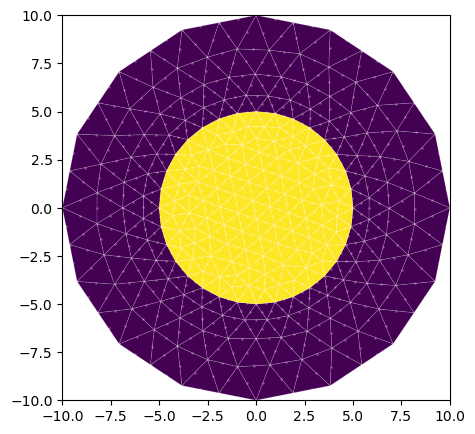

In [53]:
ncore = 1.4504
nclad = 1.444
IOR_dict_fib = {'core': ncore,'cladding':nclad}
mesher.plot_mesh(fib,IOR_dict_fib)

### 1.2 **solving for fiber modes**
With our mesh and refractive indices defined, we can use the `solve_waveguide()` function to get the propagating modes and effective indices

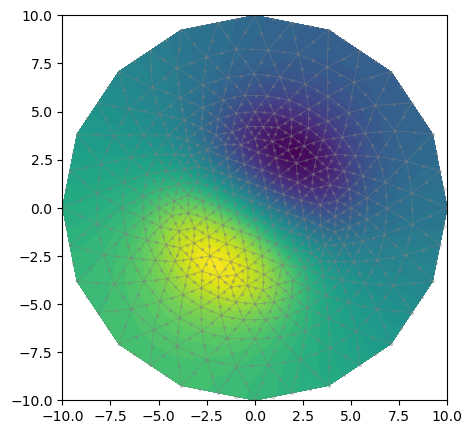

In [54]:
from wavesolve.fe_solver import solve_waveguide,plot_scalar_mode

w_fib,v_fib,N_fib = solve_waveguide(fib,wavelength,IOR_dict_fib,plot=False)
plot_scalar_mode(fib,v_fib[1],show_mesh=True) # plot mode 1

Note that the code returns four modes, ordered in descending eigenvalue; however the last is tagged as "spurious". FE mode solvers  will return so-called "cladding" modes that are unphysical. Whether a mode is physical or unphysical can be easily determined by looking at the corresponding eigenvalue, which can be converted to an effective index. As far as I am aware, this issue is a property of all FE solvers. The first 3 modes recovered are the usual LP01 and LP11 modes.

### 1.3 **3-port photonic lantern entrance modes**

The small end of a 3-port photonic lantern can have a triangle geometry, if the lantern is formed by fusing and tapering down a bundle of single-mode fibers. Below we use the `mesher.lantern_mesh_3PL()` function, which generates a mesh that matches the endface geometry observed in microscope images, taken of 3-port PLs at SCExAO/Subaru.

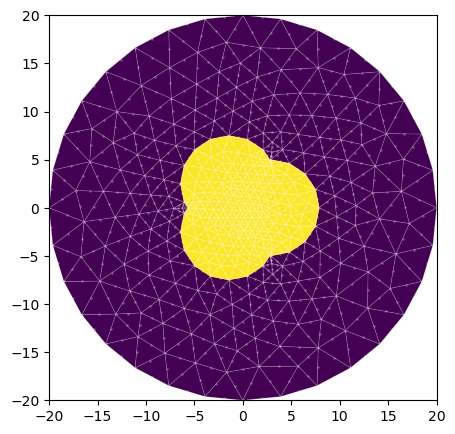

In [55]:
from wavesolve import mesher

r = 5 # the 3-port PL endface core geometry looks like three overlapping, slightly displaced circles.
      # r is the radius of each circle.
res = 16
PL = mesher.lantern_mesh_3PL(r,res)

# the two regions in the 3PL are called `cladding` and `jacket`. They are analogous to the core and cladding
# of a standard optical fiber. 
IOR_dict_lant = {'cladding': 1.444,'jacket':1.444-5.5e-3}
mesher.plot_mesh(PL,IOR_dict_lant)

Now let's solve. This time around, we'll solve in sparse mode by setting `sparse=True`. Sparse mode is far more memory efficient, but slower than the default ("dense") mode; due to memory constraints, some highly resolved waveguide meshes are probably only solvable in sparse mode.

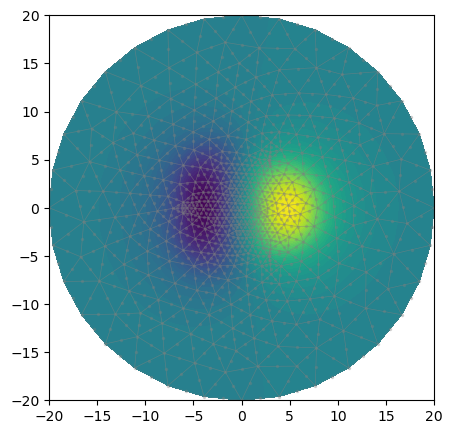

In [56]:
w_PL,v_PL,N_PL = solve_waveguide(PL,wavelength,IOR_dict_lant,plot=False)
plot_scalar_mode(PL,v_PL[1],show_mesh=True) # plot mode 1

### 1.4 **Interpolation to a grid**

Now let's project the solution (eigenfunction) to a rectangular grid. For this we provide the `interpolate()` function. An example is shown below. To speed up repeat computations you should compute pass in the optional arg `meshtree` (this is a search structure that can be computed using `mesher.construct_meshtree()`), as shown below, which enables us to quickly find which triangle a point falls in. For a fixed input mesh and output grid, interpolation can be sped up even more by pre-computing and passing in the optional args `tri_idxs` and `interp_weights`. These are intermediate arrays which depend only on the input mesh and output grid, and can be computed through `get_tri_idxs()` and `get_interp_weights()`. See Section 3.1.3 for more details.

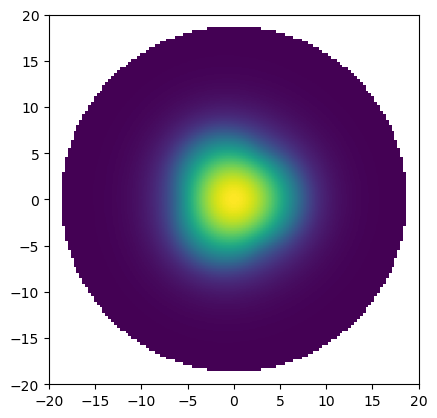

In [59]:
from wavesolve.fe_solver import interpolate,get_tri_idxs,get_interp_weights
import matplotlib.pyplot as plt
import numpy as np
from wavesolve.mesher import construct_meshtree

# first, define the rectangular grid to interpolate onto
xmax = 20 #um
ymax = 20 #um
res = 128

# make 1D arrays defining the grid
xa = np.linspace(-xmax,xmax,res)
ya = np.linspace(-ymax,ymax,res)

# interpolate the first eigenvector for the 3-port PL.
PLtree = construct_meshtree(PL)
v0_interp = interpolate(v_PL[0],PL,xa,ya,tri_idxs=None,interp_weights=None,meshtree=PLtree,maxr=19)

# or: 
# tri_idxs = get_tri_idxs(PL,xa,ya)
# weights = get_interp_weights(PL,xa,ya,tri_idxs)
# v0_interp = interpolate(v[0],PL,xa,ya,tri_idxs=tri_idxs,interp_weights=weights)

# plot - take transpose because interpolate assumes 1st axis is x, unlike imshow
plt.imshow(v0_interp.T, origin='lower', extent=(-xmax, xmax, -ymax, ymax))
plt.show()

## **2. the `waveguide` module**

`wavesolve` now comes with a `waveguide` module, which is a simplified version of a similar module that comes with `cbeam`, another package I worked on. This module is tailored for modelling 2D waveguide cross-sections. Below we go over the basic usage.

<a id='sec2.1'></a>
### **2.1 Defining waveguides**

In this section we discuss how to build waveguides from the bottom-up. In practice, users may only need to interact with the high-level `Waveguide` class covered in Section 2.1.2.

<a id='sec2.1.1'></a>
#### **2.1.1 the `Prim2D` class**

The basic parent class that represents a refractive index geometry is a `Prim2D`. Each `Prim2D` stores a refractive index value and an array of $(x,y)$ points bounding the physical region which contains that index value. A `Prim2D` is generically initialized through

**`prim2D = waveguide.Prim2D(n,label,points)`**

**Arguments**

1.  `n` : the refractive index of the primitive. 

2. `label` : a string identifier to attach to the primitive (e.g. "core" or "cladding").

3. `points` (optional): an $N\times 2$ array of $(x,y)$ points corresponding to a material interface The first and last point are automatically connected. Default is `None`, since `points` can also be generated with functional dependence, as mentioned next.  

To make specific types of geometries, users are encouraged to define subclasses that inherit from `Prim2D` and generate `points` according to specific rules. These subclasses should implement their own `make_points()` functions, which at minimum should take in some set of arguments (like radius, for a circle primitive) and return the corresponding point array. Subclasses should also implement the following functions:

> `boundary_dist(x,y)` : compute the minimum distance between the point $(x,y)$ and the primitive boundary, returning a negative value if the point is inside the boundary. 

> `nearest_boundary_point(x, y)` : compute the closest boundary point $(x_b,y_b)$ to the point $(x,y)$.

See the `Circle`, `Ellipse`, and `Rectangle` classes for examples. 

More complicated primitives can be created through `waveguide.Prim2DUnion`, representing a list of intersecting primitives, and `waveguide.Prim2DArray`, representing a list of non-intersecting primitives.

<a id='sec2.1.3'></a>
#### **2.1.2 the `Waveguide` class**

A `Waveguide` stores a (potentially nested) list of `Prim2D`s, which we will call `prim2Dgroups`. The refractive index profile of each top-level element in `prim2Dgroups` is overwritten by the immediate next element. Any element containing a list of `Prim2D`s is treated as a single `Prim2D`.$^\dagger$ So, an optical fiber might store its primitives as `[cladding,core]`, where `cladding` and `core` are `Pipe`s corresponding to the cladding and core regions; a multicore fiber could have the structure `[cladding,[core1,core2,...]]`. A `Waveguide` is generically initialized as 

**`wvg = Waveguide(prim2Dgroups)`**

**Arguments** 

1.  `prim2Dgroups` : the potentially nested list of 3D primitives mentioned above.

Like before, users are encouraged to define their own `Waveguide` subclasses, which initialize a set of `Prim2D` objects and arranges them as desired. The `Waveguide` class is mainly used to generate meshes, which can be tuned via `Waveguide` class attributes; see Section 2.2 for more details. For example `Waveguides`, check out the `CircularFiber` and `EllipticalFiber` classes. I have also implemented basic example classes for photonic crystal fibers; see Section 3.2.

$^\dagger$ `Prim2D` objects in the same sublist should never intersect. However, they can have different `label`s and refractive indices. If you want to model intersecting primitives, you should make a `Prim2DUnion`.

#### **2.1.3 the `Waveguide` class functions**

To get the refractive index dictionary of the waveguide, use `IOR_dict = Waveguide.assign_IOR()`. 

To view meshes, the `Waveguide` class implements `Waveguide.plot_mesh()`:

`Waveguide.plot_mesh()`

**Optional arguments**
1. `mesh`: the mesh to plot. If `None`, one is generated using default values through `make_mesh()`.
2. `IOR_dict`: dictionary of refractive index values. If `None`, one is generated through `assign_IOR()`.

#### **2.2 Mesh generation**

Mesh generation is primarily handled through the `Waveguide` class functions `make_mesh()`, which can be called using

`make_mesh(algo,order,adaptive):`

**Arguments**

1. `algo` : the mesh generation algorithm used by Gmsh. The default `6` is good starting point.
2. `order` : the order of the finite elements. Order `1` (linear triangle) and `2` (quadratic triangle) are implemented; default `2`.

**Optional**
3. `adaptive`: whether or not to refine mesh element sizes so that the mesh is most refined only at primitive boundaries; default `False`. 

When using the mode `adaptive=True`, a target mesh size is computed over the computation region as function of $(x,y)$. For a single `Prim2D` object, a target mesh size at a given $(x,y)$ point is computed as 

$$
{\rm target \, size} = d_0\left(1+ \dfrac{s \, d(x,y)}{d_0} \right)^p
$$
where $d_0$ is the "default" mesh size set by the resolution of the `Prim2D` boundary, $d(x,y)$ is the distance between the point $(x,y)$ and the primitive's boundary, and $s$ and $p$ are variables. The default values for both $s$ and $p$ are 1; higher values mean that mesh size will increase more rapidly away from the boundary. For multiple primitives, a target size is computed for each and the minimum size is taken. Then the target size is clipped between a minimum and maximum allowed value. This function is implemented in

`Waveguide.compute_mesh_size(x,y,_scale,_power,min_size,max_size)`

where the `_scale` and `_power` args correspond to $s$ and $p$. The parameter values for the adaptive scheme are set through the following `Waveguide` class attributes:

> `mesh_dist_scale` : $s$, the mesh boundary refinement linear distance scaling. Default 1

> `mesh_dist_power` : $p$, mesh boundary refinement power scaling. Default 1

> `min_mesh_size` : minimum allowed mesh size, default 0.1

> `max_mesh_size` : maximum allowed mesh size, default 10

Users can also specify a target mesh size, and toggle boundary refinement on a per-primitive basis. This is done through the following `Prim2D` attributes: 

> `mesh_size` : target mesh size within the boundary of the primitive (otherwise the mesh size is set by the scheme described above.)

> `skip_refinement` : whether or not mesh refinement should be applied at the primitive boundary. The outer boundary of the entire mesh should have this set to `True`; default `False`.


#### **2.3 Example: elliptical core fiber**
Below we use the `waveguide` module to make an elliptical fiber.

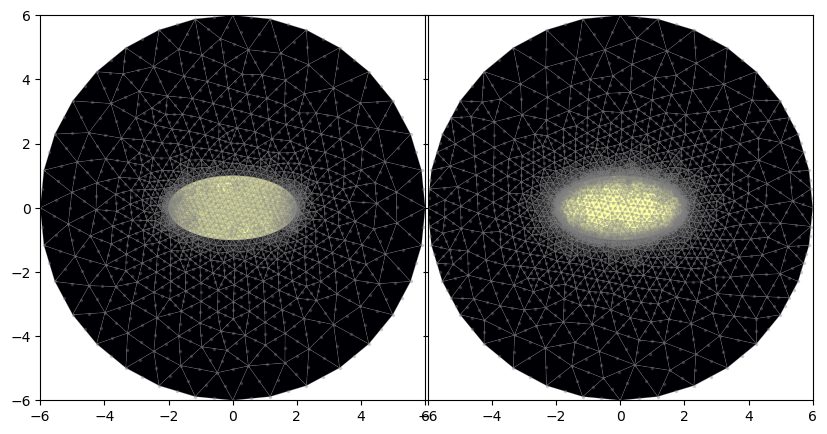

In [48]:
from wavesolve import waveguide
import matplotlib.pyplot as plt

## params 
ncore = 1.444+5e-2
nclad = 1.444
acore = 2. # extent of the elliptical core along the x axis
bcore = 1. # extent of the elliptical core along the y axis
rclad = 6. # cladding radius
res = 64 # resolution for core boundary

## make the fiber

# 1. first init a core object
core = waveguide.Ellipse(ncore,"core")

# 2. next generate the points
core.make_points(acore,bcore,res)

# 3. similarly, make a cladding object
clad = waveguide.Circle(nclad,"cladding")
clad.make_points(rclad,int(res/2))

# 4. now assemble into waveguide
fiber = waveguide.Waveguide([clad,core])

# 5. make the mesh - test both adaptive = False and True
mesh = fiber.make_mesh(adaptive=False)

fiber.mesh_dist_scale = 0.25 # lowering distance scale from default of 1.
mesh_ref = fiber.make_mesh(adaptive=True)

# 6. let's view meshes
fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True)

fiber.plot_mesh(mesh,ax=axs[0])
fiber.plot_mesh(mesh_ref,ax=axs[1])
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

## **3. `fe_solver` module**

### **3.1. Scalar modes**

A scalar mode assigns a scalar field amplitude to every node in the mesh. For order 1 triangular elements, every node is a triangle vertex. For order 2 elements, nodes also appear at the midpoints of triangle edges.

#### 3.1.1. **Solving**

Given a finite element mesh, we can use the function `fe_solver.solve_waveguide()` to get the scalar eigenmodes. The signature is as follows:

`solve_waveguide()`

**Arguments**

1. `mesh`: mesh object corresponding to waveguide geometry
2. `wl`: wavelength, defined in the same units as mesh point positions
3. `IOR_dict`: a dictionary assigning different named regions of the mesh different refractive index values
4. `plot`: set True to view eigenmodes
5. `ignore_warning`: bypass the warning raised when the mesh becomes too large to solve safely with scipy.linalg.eigh()
6. `sparse`: set True to use a sparse solver, which is can handle larger meshes but is slower
7. `Nmax`: return only the `Nmax` largest eigenvalue/eigenvector pairs
8. `order`: the order of the triangular finite elements. can be 1 (linear) or 2 (quadratic) ; default 2. Must match the order of `mesh`

**Returns**
1. `w`: array of eigenvalues, descending order
2. `v`: array of corresponding eigenvectors (waveguide modes)
3. `N`: number of non-spurious eigenmodes.

Example usage was given in Section 1. 

#### 3.1.2. **Plotting**

To plot eigenmodes, use

`plot_scalar_mode(mesh,v,show_mesh,ax)`

**Arguments**
1.  `mesh`: finite element mesh
2.  `v`: an array (column vector) corresponding to an eigenmode
3.  `show_mesh`: set True to additionally plot the mesh geometry
4.  `ax`: optionally put the plot on a specific matplotlib axis

#### 3.1.3. **Interpolation**

Interpolation onto regular grids is handled via `interpolate()`, which was also covered in Section 1. The signature is:

`v = interpolate(v,mesh,xa,ya)`

**Arguments**

1.    `v`: eigenvector to interpolate 
2.    `mesh`: mesh object corresponding to waveguide geometry
3.    `xa`: 1D array of x points for output grid
4.    `ya`: 1D array of y points for output grid

**Optional Arguments**

5.    `tri_idxs`: an array of indices. the first index corresponds to the first triangle containing the first mesh point, etc. auto-computed if `None`.
6.    `interp_weights`: interpolation weights. these are multiplied against v and summed to get the interpolated field. auto-computed if `None`.
7.    `mesh_tree`: a KDtree representing the mesh triangles. auto-computed if `None`
8.    `order`: the order of the finite element mesh
9.    `maxr`: points more than this distance from the origin are ignored in the interpolation. if 0, all points are assumed to lie inside the mesh (which can make things slow if some points are actually outside.)

**Returns**

1. `v`: the mode interpolated over the rectangular grid (xa,ya)

#### **3.1.4. Example - circular fiber**
In this example we generate a circular step-index fiber with the `waveguide` class. Then we generate an order 2 mesh and solve it using `solve_waveguide()`.

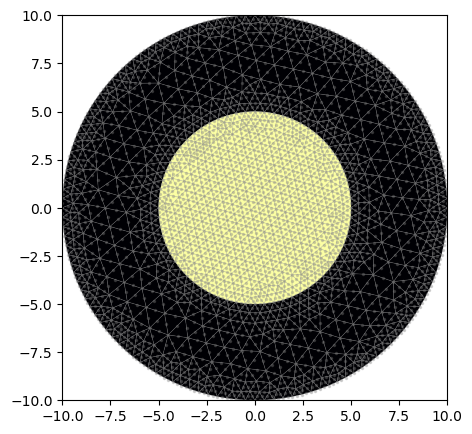

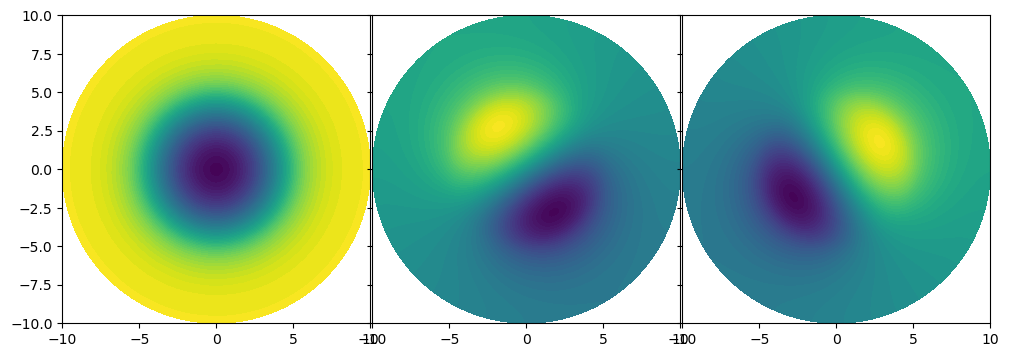

In [2]:
from wavesolve.fe_solver import plot_scalar_mode,solve_waveguide
from wavesolve import waveguide
import matplotlib.pyplot as plt

rcore = 5
rclad = 10
ncore = 1.444+8.8e-3
nclad = 1.444

# 3-mode fiber
circular_fiber = waveguide.CircularFiber(rcore,rclad,ncore,nclad,64,128,core_mesh_size=0.5)

wl = 1.55 #um
IOR_dict = circular_fiber.assign_IOR()
circular_fiber.mesh_dist_scale = 0.25
mesh = circular_fiber.make_mesh(order=2,adaptive=True)
circular_fiber.plot_mesh(mesh)

_w,_v,_n = solve_waveguide(mesh,wl,IOR_dict,plot=False,Nmax=3)

fig,axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,4))

for i,ax in enumerate(axs):
    ax.set_aspect('equal')
    plot_scalar_mode(mesh,_v[i],show_mesh=False,ax=ax)

plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

### **3.2 Vector modes**

In `wavesolve`, vector modes are divided into transverse and longitudinal components. The longitudinal component is treated in the same way as a scalar mode, which has a defined value at every node position. In contrast, the transverse electric field is specified by assigning a value for the tangential electric field to every mesh edge (here "tangential" is with respect to the edge). This approach guarantees that the boundary conditions for Maxwell's equations are fulfilled. If $N_e$ is the number of mesh edges and $N_n$ is the number of nodes, a vector mode is an $(N_e+N_n)\times 1$ array whose first $N_e$ elements determine the transverse field and whose last $N_n$ components determine the longitudinal field.

#### **3.2.1. Solving**

To solve for the vector modes, we can use `fe_solver.solve_waveguide_vec()`. The vectorial solver is only implemented for linear triangle elements (`order=1`). The call signature is the same as `solve_waveguide()` except the optional `order` argument is omitted. Additionally, you can select one of two sparse solving schemes through the new optional argument:

`sparse_solve_mode = "factorize"` : (default) the eigenproblem $A x =\lambda B x$ is transformed to $Cx = \lambda x$ where $C$ solves $BC = A$ ; $C$ is computed with `scipy`'s `spsolve` and the eigenproblem is solved with `eigs`. This option is slower, but consistently accurate.

`sparse_solve_mode = "straight"` : the eigenproblem is plugged directly into `scipy`'s `eigsh` solver. This is the fastest and most memory efficient, but occasionally returns garbage. I presume this is due to issues with the positive-definitess of $B$. 

#### **3.2.1 Plotting, interpolation**

To plot a vector eigenmode, use `plot_vector_mode()`, which has the same signature as `plot_scalar_mode()` but produces a quiver plot corresponding to the transverse component of the electric field. The longitudinal component can be plotted using `plot_scalar_mode()`. To access the transverse and longitudinal components of the vector, you will need to know the number of edges and points in your mesh. These values are stored in the attributes `mesh.num_edges` and `mesh.num_points`.

To interpolate, use `interpolate_vec()`, which has the same signature as `interpolate()`.

#### **3.2.3 Example: vector modes of circular fiber**

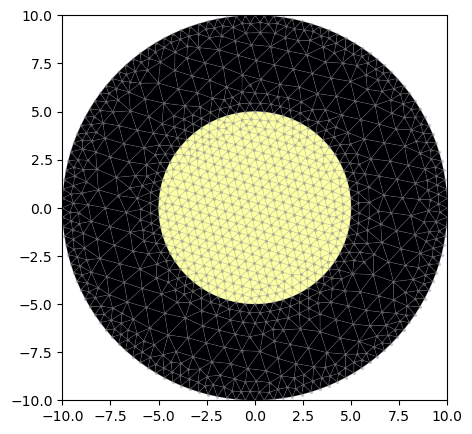

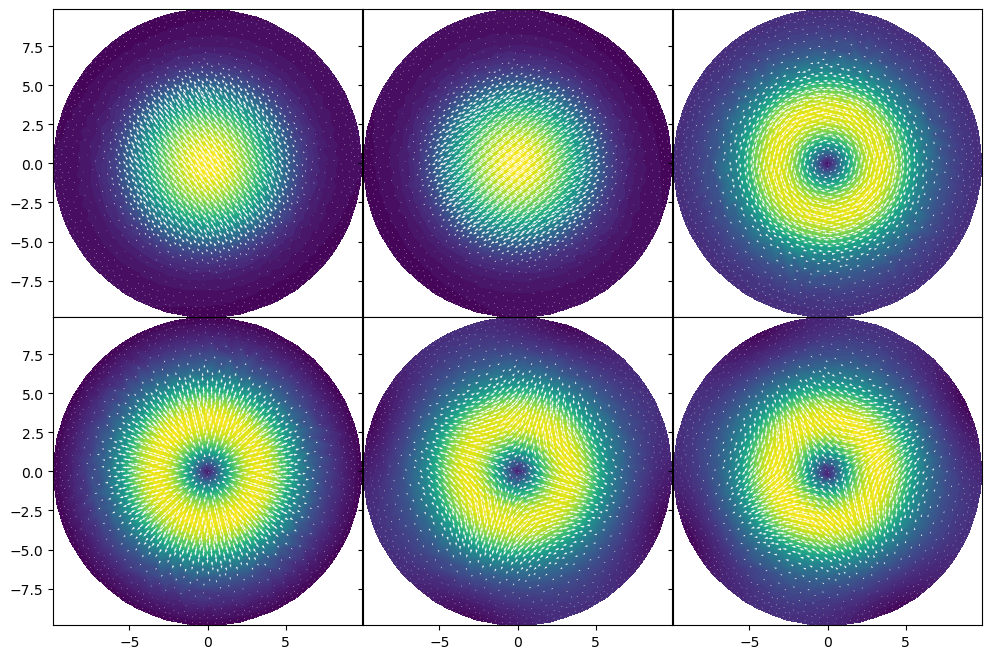

In [3]:
from wavesolve.fe_solver import solve_waveguide_vec,plot_vector_mode
from wavesolve import waveguide
import matplotlib.pyplot as plt

rcore=5
rclad = 10
ncore = 1.444+8.8e-3
nclad = 1.444

circular_fiber = waveguide.CircularFiber(rcore,rclad,ncore,nclad,64,128,core_mesh_size=0.5)

wl = 1.55 #um
IOR_dict = circular_fiber.assign_IOR()
circular_fiber.mesh_dist_scale = 0.25
mesh = circular_fiber.make_mesh(order=1,adaptive=True)
circular_fiber.plot_mesh(mesh)

_w,_v,_n = solve_waveguide_vec(mesh,wl,IOR_dict,plot=False,Nmax=10)

fig,axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(12,8))

for i,ax in enumerate(axs.flatten()):
    ax.set_aspect('equal')
    plot_vector_mode(mesh,_v[i],show_mesh=False,ax=ax)

plt.subplots_adjust(hspace=0,wspace=0)

plt.show()

## **4. Misc examples**

### **4.1 Index-guiding photonic crystal fiber**
A typical index-guiding photonic crystal fiber contains a cladding regularly perforated with air holes. A region of some characteric radius near the center of the fiber remains unperforated, and ultimately composes the "core" of the fiber. Below is an example. First, we'll make a mesh using the `PhotonicCrystalFiber` class. (When meshing adaptively, mesh generation takes longer for this structure because distances need to be every waveguide boundary.)

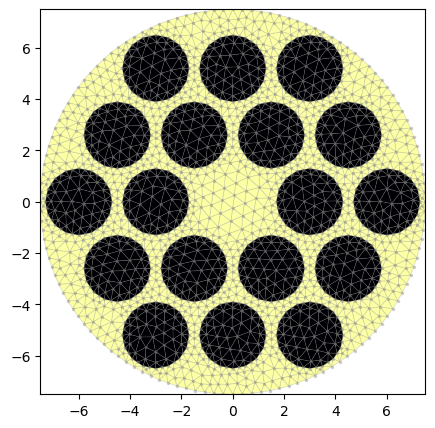

In [1]:
from wavesolve.waveguide import PhotonicCrystalFiber

hole_radius = 1.3
clad_radius = 7.5
hole_separation = 3.
nclad = 1.444
hole_res = 16
clad_res = 64
wl=1.55

PCF = PhotonicCrystalFiber(hole_radius,clad_radius,nclad,hole_separation,hole_res,clad_res,hole_mesh_size=1.0,clad_mesh_size=0.5)

m = PCF.make_mesh(order=1,adaptive=True)
PCF.plot_mesh(m)

Then, we'll use the vector solver to get the modes. This particular arrangement only has fundamental modes.

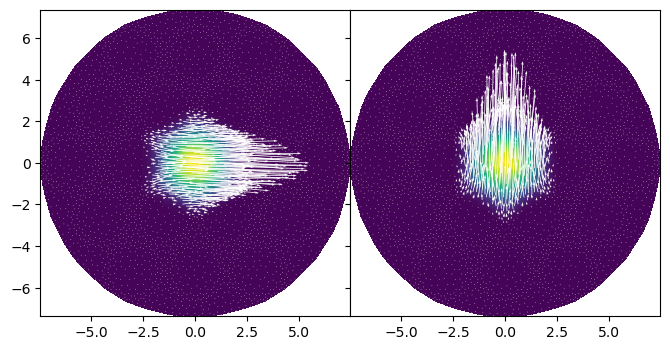

In [2]:
from wavesolve.fe_solver import solve_waveguide_vec,plot_vector_mode
import matplotlib.pyplot as plt

IOR_dict = PCF.assign_IOR()
w,v,n = solve_waveguide_vec(m,wl,IOR_dict,plot=False,Nmax=10,sparse_solve_mode="factorize")

fig,axs = plt.subplots(1,2,sharey=True,figsize=(8,4))
for i,ax in enumerate(axs):
    ax.set_aspect('equal')
    plot_vector_mode(m,v[i],ax=axs[i])


plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

We'll also plot the longitudinal component of the electric field. This field is defined over the nodes of the mesh, so we can use `plot_scalar_mode()`.

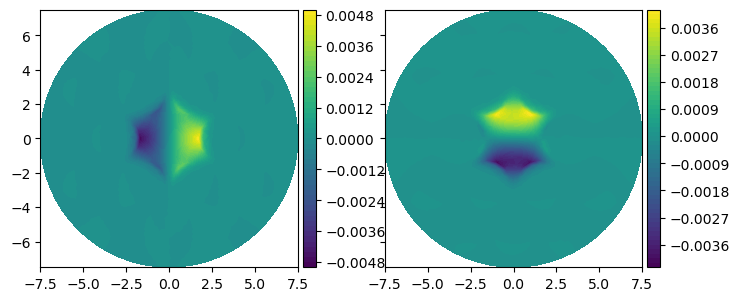

In [4]:
from wavesolve.fe_solver import plot_scalar_mode
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

Ne = m.num_edges # number of mesh edges

fig,axs = plt.subplots(1,2,sharey=True,figsize=(8,4))


for i,ax in enumerate(axs):
    im = plot_scalar_mode(m,np.real(v[i,Ne:]),ax=ax) # the longitudinal components are at the end of the vector

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.subplots_adjust(wspace=0.25)
plt.show()

We can also evaluate the vector-valued tangential component of the electric field over a rectangular grid.

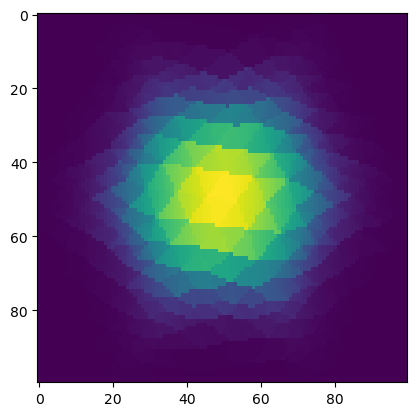

In [5]:
from wavesolve.fe_solver import interpolate_vec
import numpy as np

xa = ya = np.linspace(-3,3,100)
xg,yg=np.meshgrid(xa,ya)

v_interp = interpolate_vec(v[0],m,xa,ya)

plt.imshow(np.linalg.norm(v_interp,axis=2)) # plotting modulus
plt.show()

Interestingly, the triangle boundaries of the mesh are visible. I think this is because the vector FEM approach we're using is edge-based, assigning a tangential component to the electric field along the edge of every triangle. Doing so ensures tangential continuity everywhere, but does not enforce normal continuity, so the modulus of the vector field is overall discontinuous. 

### **4.2 Hollow core photonic crystal fiber**
In contrast with index-guiding photonic crystal fibers, hollow core fibers guide light in a region that is typically of lower index than the waveguide material. In this case, guidance is provided by the so-called photonic bandgap, which is analogous the electronic gap between Brillouin zones in crystals. Such modes are trickier to model because they have lower effective index, and might be hard to distinguish from cladding modes. In these cases, you may have to search for modes by specifying a target effective index for the guided mode.

Below is an example. First we'll make the mesh.

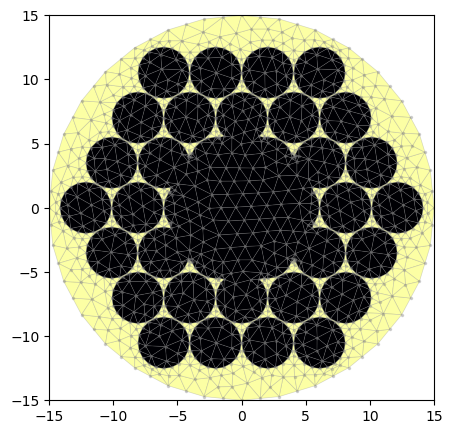

In [3]:
from wavesolve.waveguide import PhotonicBandgapFiber

# this specs are loosely based off the images I found of NKT hollow core fibers.
void_radius = 11.5/2
hole_radius = 2.
clad_radius = 15.
nclad = 1.444
hole_separation = 4.05

hollow_PCF = PhotonicBandgapFiber(void_radius,hole_radius,clad_radius,nclad,hole_separation,20,32,hole_mesh_size=1.2,clad_mesh_size=2.)

m = hollow_PCF.make_mesh(order=1,adaptive=True)
hollow_PCF.plot_mesh(m)

Next, let's solve. The voids in this fiber have index 1, so will search for modes with the largest indices at and below 1.

(Actually I already ran this and found the fundamental modes had an index of 0.995, so I will cheat and use that value.)

effective indices:  [0.99497623 0.99499838]


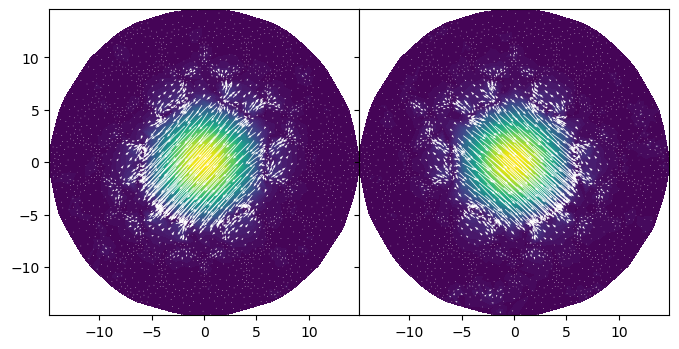

In [10]:
from wavesolve.fe_solver import get_eff_index,solve_waveguide_vec,plot_vector_mode
import matplotlib.pyplot as plt

IOR_dict = hollow_PCF.assign_IOR()
wl = 1.65

# we'll use sparse_solve_mode = "straight", which uses the eigsh solver - when it works it's faster than eigs
w,v,n = solve_waveguide_vec(m,wl,IOR_dict,plot=False,target_neff=0.995,Nmax=2,sparse_solve_mode="straight")

print("effective indices: ", get_eff_index(wl,w))

fig,axs = plt.subplots(1,2,sharey=True,figsize=(8,4))
for i,ax in enumerate(axs):
    ax.set_aspect('equal')
    plot_vector_mode(m,v[i],ax=axs[i])
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

Longitudinal component:

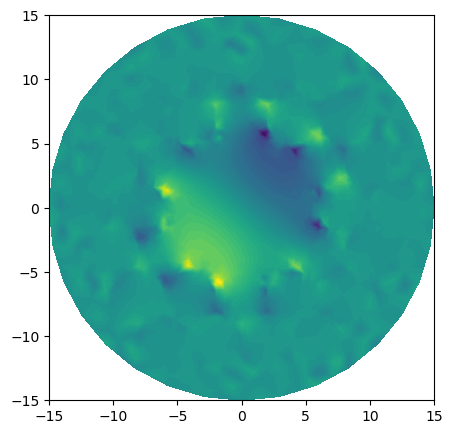

In [16]:
from wavesolve.fe_solver import plot_scalar_mode
Ne = m.num_edges
plot_scalar_mode(m,v[0,Ne:])

### 4.3 Known issues

Below are some current issues in the code.

1. Mesh generation with `adaptive=True` takes a while, but is necessary for complex geometries. The main issue is scaling: as the complexity of the waveguide goes up, the number of boundaries goes up, and it becomes more expensive to determine the distance to the nearest waveguide boundary.

2. The sparse vector solver is slow (which is partially expected) but it also occasionally runs out of memory. This is because the default solving scheme is to convert the generalized eigenvalue problem into a normal one using `scipy.sparse.linalg.spsolve` and then solve the normal problem with `scipy.sparse.linalg.eigs`. The first step can cause out-of-memory issues. In principle, we should be able to avoid this better by using `eigsh`, but `eigsh` sometimes spits out garbage - possibly because the RHS "mass" matrix is not always positive definite.

3. The plotting and interpolation need to be improved, esp. on the vector side. Some of these arrow plots look terrible.